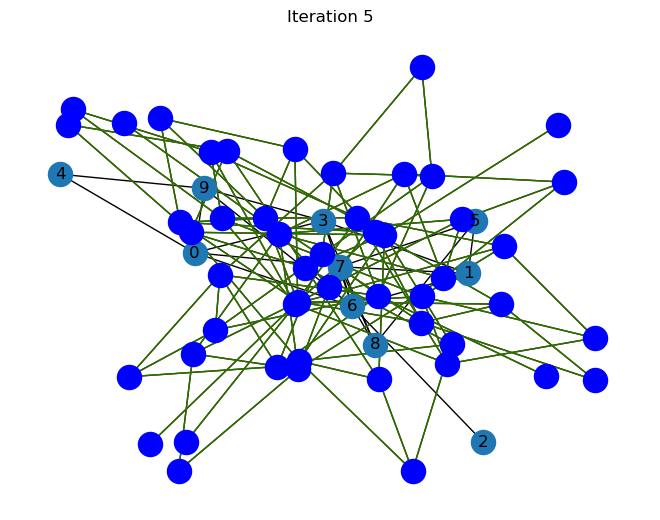

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Generate a random graph with 10 nodes and 20 edges
G = nx.gnm_random_graph(10, 20)

# Generate random features for each node
node_features = np.random.rand(10, 5)

# Generate random weights for each edge
edge_weights = np.random.rand(20, 1)

# Draw the initial graph
fig = plt.figure()
nx.draw(G, with_labels=True)
plt.title('Iteration 0')
plt.savefig('iteration_0.png')

# Perform 5 iterations of message passing
for i in range(1, 6):
    # Initialize the message dictionary for each node
    messages = {node: np.zeros((5,)) for node in G.nodes()}
    
    # Compute the messages for each edge
    for u, v in G.edges():
        messages[u] += edge_weights[(u * 2 + v) % 20] * node_features[v]
        messages[v] += edge_weights[(u * 2 + v) % 20] * node_features[u]
        
    # Update the node features with the received messages
    node_features = np.array([node_features[node] + messages[node] for node in G.nodes()])
    
    # Draw the updated graph with the relevant nodes and edges highlighted
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='blue')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in G.edges() if messages[u][0] > 0], edge_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in G.edges() if messages[v][0] > 0], edge_color='green')
    plt.title('Iteration {}'.format(i))
    plt.savefig('iteration_{}.png'.format(i))
    
# Combine the images into a gif
images = []
for i in range(6):
    filename = 'iteration_{}.png'.format(i)
    images.append(Image.open(filename))

images[0].save('message_passing.gif', save_all=True, append_images=images[1:], duration=500, loop=0)


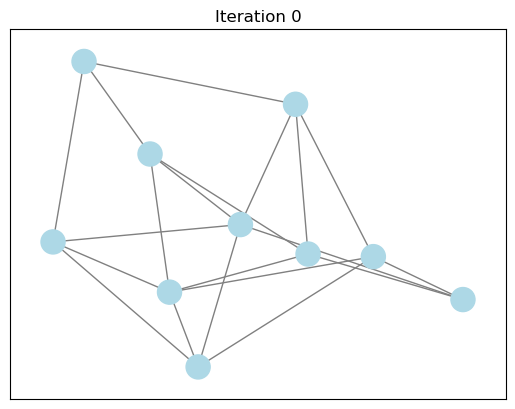

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Generate a random graph with 10 nodes and 20 edges
G = nx.gnm_random_graph(10, 20)

# Generate random features for each node
node_features = np.random.rand(10, 5)

# Generate random weights for each edge
edge_weights = np.random.rand(20, 1)

# Draw the initial graph
node_color_map = {node: 'lightblue' for node in G.nodes()}
edge_color_map = {edge: 'gray' for edge in G.edges()}
pos = nx.spring_layout(G)
fig = plt.figure()
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=[node_color_map[node] for node in G.nodes()])
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=[edge_color_map[edge] for edge in G.edges()])
plt.title('Iteration 0')
plt.savefig('iteration_0.png')

# Perform 5 iterations of message passing
for i in range(1, 6):
    # Initialize the message dictionary for each node
    messages = {node: np.zeros((5,)) for node in G.nodes()}
    
    # Compute the messages for each edge
    for u, v in G.edges():
        messages[u] += edge_weights[(u * 2 + v) % 20] * node_features[v]
        messages[v] += edge_weights[(u * 2 + v) % 20] * node_features[u]
        
    # Update the node features with the received messages
    node_features = np.array([node_features[node] + messages[node] for node in G.nodes()])
    
    # Draw the updated graph with the relevant nodes and edges highlighted
    node_color_map = {node: 'lightblue' for node in G.nodes()}
    edge_color_map = {edge: 'gray' for edge in G.edges()}
    for u, v in G.edges():
        if messages[u][0] > 0:
            edge_color_map[(u, v)] = 'red'
            node_color_map[u] = 'red'
        if messages[v][0] > 0:
            edge_color_map[(u, v)] = 'green'
            node_color_map[v] = 'green'
    fig = plt.figure()
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=[node_color_map[node] for node in G.nodes()])
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=[edge_color_map[edge] for edge in G.edges()])
    plt.title('Iteration {}'.format(i))
    plt.savefig('iteration_{}.png'.format(i))
    plt.close()
    
# Combine the images into a GIF
images = []
for i in range(6):
    filename = 'iteration_{}.png'.format(i)
    images.append(Image.open(filename))

images[0].save('message_passing.gif', save_all=True, append_images=images[1:], duration=500, loop=0)

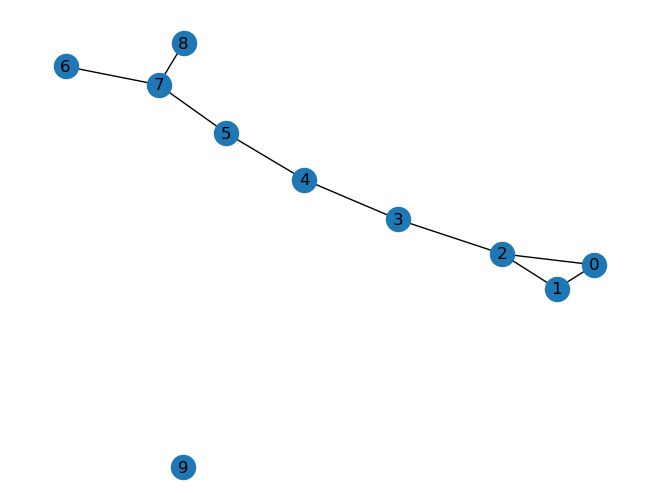

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

class MPGNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MPGNN, self).__init__()
        self.conv1 = nn.Conv1d(num_features, 32, kernel_size=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x.transpose(1, 2)))  # Transpose to [batch_size, input_length, num_features]
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=x.shape[2])
        x = x.squeeze()
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Create a toy dataset
num_features = 5  # Update num_features to match the input tensor
num_classes = 2
num_samples = 10
x = torch.randn(num_samples, num_features, num_features)  # Make sure the input tensor has the correct shape
model = MPGNN(num_features, num_classes)
# Create a random graph
edge_index = torch.tensor([[0, 1, 2, 2, 3, 4, 4, 5, 6, 7],
                           [1, 2, 0, 3, 4, 3, 5, 7, 7, 8]])

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()
for epoch in range(100):
    optimizer.zero_grad()
    output = model(x, edge_index)
    loss = criterion(output, torch.tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 1]))
    loss.backward()
    optimizer.step()

# Convert edge_index to an adjacency matrix
adj_matrix = torch.zeros((num_samples, num_samples))
for i, j in edge_index.t().tolist():
    adj_matrix[i][j] = 1
    adj_matrix[j][i] = 1

# Create a NetworkX graph object
G = nx.from_numpy_array(adj_matrix.numpy())

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

In [8]:
import torch_geometric.utils as utils

# Define a dummy input to the GNN
x = torch.randn(10, 16)  # 10 nodes with 16-dimensional features

# Define a random edge index and edge weight
edge_index = torch.randint(0, 10, size=(2, 20))
edge_weight = torch.randn(20, 1)

# Create an instance of the GNN
gnn = GNN(16, 8)

# Generate a diagram of the GNN architecture
utils.to_networkx(gnn, )


AttributeError: 'GNN' object has no attribute 'num_nodes'